## <center>Selección de Atributos en Aprendizaje de Máquina </center>

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
class Individual:
    def __init__(self, chromosome):
        self.chromosome = chromosome[:]
        self.fitness = -1

In [3]:
class Crossover:
    
    def __init__(self):
        self.crossover_rate = 0.5
    
    def onepoint(self, chromosome1, chromosome2):
        point = random.randrange(len(chromosome1))
        indiv1 = Individual(chromosome1[:point] + chromosome2[point:])
        indiv2 = Individual(chromosome2[:point] + chromosome1[point:])
        return [indiv1, indiv2]

    def uniform(self, chromosome1, chromosome2):
        new_chromosome1, new_chromosome2 = [], []
        for i in range(len(chromosome1)):
            if random.uniform(0, 1) < self.crossover_rate:
                new_chromosome1.append(chromosome1[i])
                new_chromosome2.append(chromosome2[i])
            else:
                new_chromosome1.append(chromosome2[i])
                new_chromosome2.append(chromosome1[i])
        
        indiv1 = Individual(new_chromosome1)
        indiv2 = Individual(new_chromosome2)
        return [indiv1, indiv2]

In [4]:
class Mutation:
    
    def __init__(self):
        self.mutation_rate = 0.5
    
    def bitflip(self, chromosome):
        new_chromosome = deepcopy(chromosome)
        gene = random.randrange(0, len(new_chromosome))
        new_chromosome[gene] = 0 if new_chromosome[gene] == 1 else 1
        
        return Individual(new_chromosome)
        
    def bitwise(self, chromosome):
        new_chromosome = deepcopy(chromosome)
        for i in range(len(new_chromosome)):
            if random.uniform(0, 1) >= self.mutation_rate:
                new_chromosome[i] = 0 if new_chromosome[i] == 1 else 1
                
        return Individual(new_chromosome)
    
    def inversion(self, chromosome):
        new_chromosome = deepcopy(chromosome)
        gens = sorted(np.random.permutation(len(chromosome))[:2])
        
        partial = np.flip(new_chromosome[gens[0]:gens[1]], axis=0)
        new_chromosome[gens[0]:gens[1]] = partial
        
        return Individual(new_chromosome)

In [5]:
class ParentSelection:
    
    def roulette(self, population):
        population_size = len(population)
        
        total_fitness = sum([individual.fitness for individual in population])
        select_fitness = random.uniform(0, total_fitness)
        
        # Seleccionamos el primer padre
        curr_fitness = 0
        for i, individual in enumerate(population):
            curr_fitness += individual.fitness
            if curr_fitness > select_fitness:
                parent1 = i
                break
        
        indiv1 = population[parent1]
        
        # Quitamos el fitnes del primer padre seleccionado
        total_fitness -= population[parent1].fitness
        select_fitness = random.uniform(0, total_fitness)
        
        # Seleccionamos el segundo padre
        curr_fitness = 0
        for i, individual in enumerate(population):
            if i == parent1: continue
            curr_fitness += individual.fitness
            if curr_fitness > select_fitness:
                parent2 = i
                break

        indiv2 = population[parent2]
        
        return (indiv1, indiv2)
    
    def tournament(self, population, tournament_size = 3):
        individuals = []
        x_indices = np.random.permutation(len(population))
        y_indices = x_indices[:tournament_size]
        
        for i in range(tournament_size):
            individuals.append(population[y_indices[i]].fitness)
        
        parent1 = np.argmax(individuals)
        indiv1 = population[x_indices[parent1]]
        
        
        individuals = []
        x_indices = np.delete(x_indices, parent1)
        x_indices = np.random.permutation(x_indices)
        y_indices = x_indices[:tournament_size]

        for i in range(tournament_size):
            individuals.append(population[y_indices[i]].fitness)
        
        parent2 = np.argmax(individuals)
        indiv2 = population[parent2]
        
        return (indiv1, indiv2)

In [6]:
class SurvivorSelection():
    
    def ranking(self, population, offspring, num_survivors):
        next_population = []
        population.extend(offspring)
        survivors = sorted(population, key=lambda indiv: indiv.fitness, reverse=True)[:num_survivors]
        next_population = survivors
        return next_population

In [7]:
def fitness(individual, model, data):
    idx_cols = [i for i, c in enumerate(individual.chromosome) if c == 1]
    x_train, x_test, y_train, y_test = data['x_train'], data['x_test'], data['y_train'], data['y_test']
    x_train = x_train[:, idx_cols]
    x_test = x_test[:, idx_cols]
    
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    
    return accuracy_score(y_test, y_pred)

def create_population(population_size, chromosome_size):
    population = []
    for i in range(population_size):
        chromosome = [random.randint(0,1) for c in range(chromosome_size)]
        population.append(Individual(chromosome))
    
    return population

In [8]:
class GeneticAlgorithm():
    
    def __init__(self, population, fitness, model, X, y, test_size=0.33, do_train_test_split=True, 
                 num_generations=100, mutation_per=0.5, 
                 crossover='uniform', mutation='bitwise', 
                 selection_parents='tournament', verbose=False):
        
        self.model = model
        self.X = X
        self.y = y
        self.test_size = test_size
        if do_train_test_split: self.__apply_train_test_split()
        self.population = population
        self.population_size = len(population)
        self.fitness = fitness
        self.num_generations = num_generations
        self.mutation_per = mutation_per
        self.crossover = crossover
        self.mutation = mutation
        self.selection_parents = selection_parents
        self.verbose = verbose
        self.best_individuals = []
        
            
    def __apply_train_test_split(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, 
                                                                                self.y, 
                                                                                test_size=self.test_size) #,random_state=2020
    
    def __evaluate(self, population_eval):
        for individual in population_eval:
            if individual.fitness == -1:
                data = {'x_train': self.X_train, 'x_test': self.X_test,
                        'y_train': self.y_train, 'y_test': self.y_test }
                individual.fitness = self.fitness(individual, self.model, data)
    
    def optimize(self):    
        # Creamos Crossover
        crossover = Crossover()
        # Creamos Mutación
        mutation = Mutation()
        # Creamos Parent Selection
        parent_selection = ParentSelection()
        # Creamos Survivor Selection
        survivor_selection = SurvivorSelection()
        
        # Paso 0: Evaluar la primera generación
        self.__evaluate(self.population)
        best_individual = sorted(self.population, key=lambda individual: individual.fitness, reverse=True)[:1]
        self.best_individuals.append(best_individual[0])
        
        if self.verbose:
            print(f'Generción: Inicial')
            print(f'Mejor Individuo: {best_individual[0].chromosome}\nFitness: {best_individual[0].fitness}')
        
        for generation in range(self.num_generations):
            # Paso 1: Selección de padres
            mating_pool = []
            for i in range(int(self.population_size / 2)):
                if self.selection_parents == 'roulette':
                    mating_pool.append(parent_selection.roulette(self.population))
                elif self.selection_parents == 'tournament':
                    mating_pool.append(parent_selection.tournament(self.population))
                else:
                    raise NotImplementedError
            
            # Paso 2: Cruzamiento de cromosomas
            offspring_population = []
            for i in range(len(mating_pool)):
                if self.crossover == 'onepoint':
                    offspring_population.extend(crossover.onepoint(mating_pool[i][0].chromosome, mating_pool[i][1].chromosome))
                elif self.crossover == 'uniform':
                    offspring_population.extend(crossover.uniform(mating_pool[i][0].chromosome, mating_pool[i][1].chromosome))
                    pass
                else:
                    raise NotImplementedError
            
            # Paso 3: Mutación de cromosomas
            for i in range(len(offspring_population)):
                if random.uniform(0, 1) < self.mutation_per:
                    if self.mutation == 'bitflip':
                        offspring_population[i] == mutation.bitflip(offspring_population[i].chromosome)
                    elif self.mutation == 'bitwise':
                        offspring_population[i] == mutation.bitwise(offspring_population[i].chromosome)
                    elif self.mutation == 'inversion':
                        offspring_population[i] == mutation.inversion(offspring_population[i].chromosome)
                    else:
                        raise NotImplementedError
            
            # Paso 4: Evaluamos la nueva descendencia
            self.__evaluate(offspring_population)
            best_individual = sorted(self.population, key=lambda individual: individual.fitness, reverse=True)[:1]
            self.best_individuals.append(best_individual[0])
        
            if self.verbose and (generation % 10 == 0):
                print(f'Generción: {generation}')
                print(f'Mejor Individuo: {best_individual[0].chromosome}\nFitness: {best_individual[0].fitness}')
        
            # Paso 5: Seleccionamos los nuevos individuos para la sgte. generación
            # Sólo se ha implementado por 'ranking', por lo cual se hace de manera
            # directa
            self.population = survivor_selection.ranking(self.population, offspring_population, self.population_size)
            
            
            
        return self.best_individuals
            

### 1. Lectura del conjunto de datos

In [9]:
# 1.1. Leemos el conjuntos de datos a utlizar
# Dataset: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing
dataset = pd.read_csv('dataset/bank-full.csv', sep=";")

In [10]:
dataset2 = pd.read_csv('dataset/bank-additional/bank-additional-full.csv', sep=';')

In [11]:
dataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### 2. Pre-procesamiento del conjunto de datos

In [12]:
# 2.1. LabelEnconder
encoder = LabelEncoder()

In [13]:
# Codificamos los valores categoricos
def convert_categorical_to_codes(X):
    X_new = X.copy()
    for c in X_new:
        if pd.api.types.is_object_dtype(X_new[c]) == True:
            X_new[c] = encoder.fit_transform(X_new[c])
    return X_new

def preprocessing(X):
    X_new = X.copy()
    X_new = X_new[X_new['education'] != 'unknown']
    X_new = X_new[X_new['contact'] != 'unknown']
    X_new = X_new[X_new['job'] != 'unknown']
    X_new = convert_categorical_to_codes(X_new)
    return X_new

def replace_values_outliers(X, column, max_value):
    X_new = X.copy()
    stat = X_new[column].describe()
    values = X_new[column].values
    X_new[column] = np.where(np.logical_or(values < stat['min'], values > max_value), stat['mean'], values)
    return X_new

In [14]:
X = preprocessing(dataset)

In [29]:
len(X)

30907

### 3. Tratamiento de Outliers

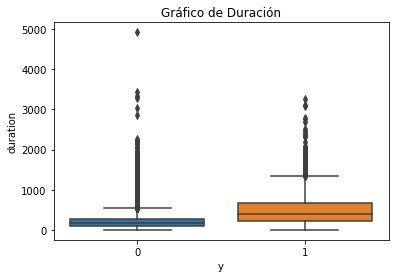

In [15]:
sns.boxplot(x='y', y='duration', data=X)
plt.title('Gráfico de Duración')
plt.show()

In [16]:
X = replace_values_outliers(X, 'duration', 1500)

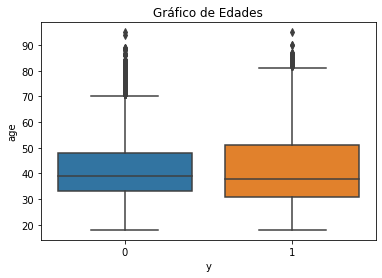

In [17]:
sns.boxplot(x='y', y='age', data=X)
plt.title('Gráfico de Edades')
plt.show()

In [18]:
X = replace_values_outliers(X, 'age', 80)

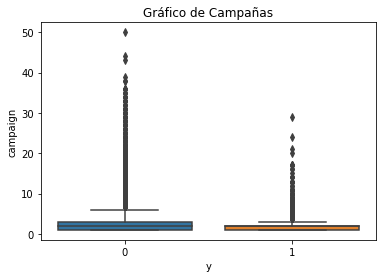

In [19]:
sns.boxplot(x='y', y='campaign', data=X)
plt.title('Gráfico de Campañas')
plt.show()

In [20]:
X = replace_values_outliers(X, 'campaign', 7)

In [21]:
X.reset_index(drop=True, inplace=True)
y = X['y']
X = X.drop(['y'], axis=1)

### 3. Escalamiento de Datos

In [22]:
# 3.1. StandardScaler
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

### 4. Pruebas Temporales

In [23]:
scores = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.33)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
print("Score del modelo usando todos los atributos: ", np.array(scores).mean())

Score del modelo usando todos los atributos:  0.8645098039215686


In [24]:
model = LogisticRegression()
kfolds = StratifiedKFold(n_splits=10)
accuracies = cross_val_score(model, X_scale, y, cv=kfolds, scoring='accuracy')
print("Score del modelo usando KFolds:", accuracies.mean())

Score del modelo usando KFolds: 0.8563097896701878


### 5. Ejecutamos el Algoritmo Genético

In [25]:
model = LogisticRegression()
best_values = []
for i in range(10):
    initial_population = create_population(population_size=50, chromosome_size=X.shape[1])
    ga = GeneticAlgorithm(deepcopy(initial_population), fitness, model, 
                          X_scale, y, test_size=0.33, do_train_test_split=True,
                          num_generations=100, mutation_per=0.5, mutation='bitflip', 
                          selection_parents='roulette', verbose=True)
    
    individuals = ga.optimize()
    individuals = sorted(individuals, key=lambda indv: indv.fitness, reverse=True)
    best_values.append(individuals[0])

Generción: Inicial
Mejor Individuo: [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
Fitness: 0.8673529411764705
Generción: 0
Mejor Individuo: [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
Fitness: 0.8673529411764705
Generción: 10
Mejor Individuo: [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1]
Fitness: 0.8695098039215686
Generción: 20
Mejor Individuo: [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1]
Fitness: 0.8695098039215686
Generción: 30
Mejor Individuo: [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1]
Fitness: 0.8695098039215686
Generción: 40
Mejor Individuo: [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1]
Fitness: 0.8695098039215686
Generción: 50
Mejor Individuo: [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1]
Fitness: 0.8695098039215686
Generción: 60
Mejor Individuo: [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1]
Fitness: 0.8695098039215686
Generción: 70
Mejor Individuo: [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1]
Fitness: 0.8695098039215686
Generción: 80
Mejor Indi

Generción: 90
Mejor Individuo: [0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1]
Fitness: 0.8663725490196078
Generción: Inicial
Mejor Individuo: [1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0]
Fitness: 0.8645098039215686
Generción: 0
Mejor Individuo: [1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0]
Fitness: 0.8645098039215686
Generción: 10
Mejor Individuo: [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
Fitness: 0.866078431372549
Generción: 20
Mejor Individuo: [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
Fitness: 0.866078431372549
Generción: 30
Mejor Individuo: [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
Fitness: 0.866078431372549
Generción: 40
Mejor Individuo: [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
Fitness: 0.866078431372549
Generción: 50
Mejor Individuo: [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
Fitness: 0.866078431372549
Generción: 60
Mejor Individuo: [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
Fitness: 0.866078431372549
Generción: 70
Mejor Individuo:

In [26]:
best_values_sorted = sorted(best_values, key=lambda indv: indv.fitness, reverse=True)

In [27]:
print("Features: ", X.columns.values)
print("*"*80)
print("")
for i, indiv in enumerate(best_values_sorted[:5]):
    print(f"Individio {i}")
    print(indiv.chromosome)
    print(indiv.fitness)
    print("-"*48)

Features:  ['age' 'job' 'marital' 'education' 'default' 'balance' 'housing' 'loan'
 'contact' 'day' 'month' 'duration' 'campaign' 'pdays' 'previous'
 'poutcome']
********************************************************************************

Individio 0
[1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]
0.8705882352941177
------------------------------------------------
Individio 1
[1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]
0.8696078431372549
------------------------------------------------
Individio 2
[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1]
0.8695098039215686
------------------------------------------------
Individio 3
[1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1]
0.8695098039215686
------------------------------------------------
Individio 4
[0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1]
0.8663725490196078
------------------------------------------------
